In [ ]:
#import several libraries
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.regularizers import L1L2
from keras.preprocessing.image import ImageDataGenerator
import csv

In [ ]:
#snippet to Google Colab and set up access to Google Drive, downloading data from Kaggle, and unzip the downloaded files.
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive/
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ColabNotebooks/inputs"
#changing the working directory
%cd "/content/gdrive/MyDrive/ColabNotebooks/inputs"
#Check the present working directory using pwd command
!pwd

#kaggle API file
! kaggle competitions download -c detect-pneumonia-spring-2024

!ls

#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip



Mounted at /content/gdrive
'Colab Notebooks'   ColabNotebooks
/content/gdrive/MyDrive/ColabNotebooks/inputs
/content/gdrive/MyDrive/ColabNotebooks/inputs
100% 1.13G/1.14G [00:14<00:00, 78.7MB/s]
100% 1.14G/1.14G [00:14<00:00, 85.4MB/s]
best_model_EfficientNetV2M_2.hdf5  final_submission412.csv
best_model_EfficientNetV2M_3.hdf5  final_submission4244.csv
best_model_EfficientNetV2M.hdf5    final_submission46.csv
best_model_effnetB0.hdf5	   final_submission52.csv
best_model_effnetB1.hdf5	   final_submission53.csv
best_model_effnetB2.hdf5	   final_submission649.csv
best_model_effnetB3_1.hdf5	   final_submission657.csv
best_model_effnetB3_2.hdf5	   final_submission658.csv
best_model_effnetB3_3.hdf5	   final_submission659.csv
best_model_effnetB3_4.hdf5	   final_submission682.csv
best_model_effnetB3_5.hdf5	   final_submission8924.csv
best_model_effnetB3_6.hdf5	   final_submission9876.csv
best_model_effnetB3_7.hdf5	   final_submission98.csv
best_model_effnetB3.hdf5	   final_submission.csv
best_

In [ ]:
#define function to load and preprocess normal X-ray images from a training dataset
def load_normal(norm_path, labels_path):
    norm_files = np.array(os.listdir(norm_path))
    labels = pd.read_csv(labels_path)

    norm_images = []
    norm_labels = []
    BLACK =[0,0,0]
    for image in norm_files:

        #get the label of each image in a list
        a = labels[labels["file_name"]==str(image)].index.values
        b = labels.iloc[a]["class_id"].values
        norm_labels.append(b)

        #transform the images
        path = norm_path + "/" + image
        image = cv2.imread(path)
        im_height, im_width, channels = image.shape
        if im_height > im_width:
          x2 = im_height - im_width
          x1 = 0
        else:
          x1 = im_width - im_height
          x2 = 0
        constant= cv2.copyMakeBorder(image,x1,x1,x2,x2,cv2.BORDER_CONSTANT, value=BLACK)
        image = cv2.resize(constant, dsize=(224,224))
        norm_images.append(image)


    norm_images = np.array(norm_images)
    norm_labels = np.array(norm_labels)

    return norm_images, norm_labels

In [ ]:
#define function to load and preprocess normal X-ray images from a test dataset.
def load_normal_test(norm_path):

    norm_files = np.array(os.listdir(norm_path))
    norm_images = []
    image_names = []
    BLACK =[0,0,0]

    for image in norm_files:

        image_names.append(image)
        #transform the images
        path = norm_path + "/" + image
        image = cv2.imread(path)
        im_height, im_width, channels = image.shape
        if im_height > im_width:
          x2 = im_height - im_width
          x1 = 0
        else:
          x1 = im_width - im_height
          x2 = 0
        constant= cv2.copyMakeBorder(image,x1,x1,x2,x2,cv2.BORDER_CONSTANT, value=BLACK)
        image = cv2.resize(constant, dsize=(224,224))
        norm_images.append(image)


    norm_images = np.array(norm_images)
    image_names = np.array(image_names)

    return norm_images, image_names

In [ ]:
#use the load_normal() function to load and preprocess normal X-ray images along with their labels from a training dataset
norm_images, norm_labels =  load_normal('/content/gdrive/MyDrive/ColabNotebooks/inputs/train_images/train_images', '/content/gdrive/MyDrive/ColabNotebooks/inputs/labels_train.csv')


In [ ]:
#use the load_normal_test() function to load and preprocess normal X-ray images along with their labels from a test dataset
norm_images_test, names =  load_normal_test('/content/gdrive/MyDrive/ColabNotebooks/inputs/test_images/test_images')


In [ ]:
#shape of the X_train variable which contains the processed images from the training dataset
X_train = norm_images
X_train.shape

(4672, 224, 224, 3)

In [ ]:
#shape for y_train that contains the labels for the corresponding images in X_train
y_train = norm_labels
y_train.shape

(4672, 1)

In [ ]:
#the shape (number_of_images, height, width, channels) for X_test that contains the processed images from the test dataset
X_test = norm_images_test
X_test.shape


(1168, 224, 224, 3)

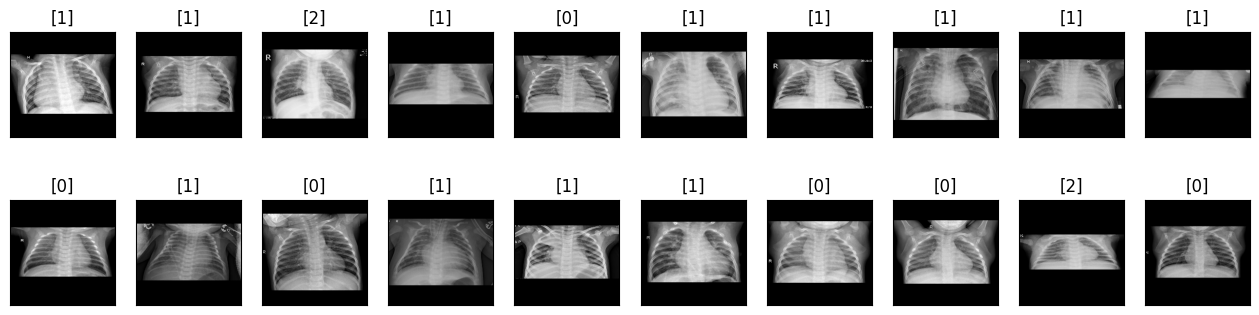

In [ ]:
#create a grid to visualize a subset of 20 random images from training images along with their corresponding labels
fig, axes = plt.subplots(ncols=10, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 20)
counter = 0

for i in range(2):
    for j in range(10):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
#use this to save the variables X_train and y_train into a file named "pneumonia_dt.pickle" using this function
with open('pneumonia_dt.pickle', 'wb') as f:
    pickle.dump((X_train, y_train), f)# Use this to load variables

In [ ]:
#use this to save the variables X_test into a file named "pneumonia_dt_test.pickle" using this function
with open('pneumonia_dt_test.pickle', 'wb') as f:
    pickle.dump((X_test), f)# Use this to load variables

In [ ]:
#converts the variable names into a pandas DataFrame and then saves it to a CSV file
pd.DataFrame(names).to_csv("submission3.csv", index=False, header = ["file_name"])


In [ ]:
#loads the variables X_train and y_train from the file "pneumonia_dt.pickle" using this function
with open('pneumonia_dt.pickle', 'rb') as f:
    (X_train, y_train) = pickle.load(f)

In [ ]:
#loads the variables X_test from the file "pneumonia_dt_test.pickle" using this function
with open('pneumonia_dt_test.pickle', 'rb') as f:
    (X_test) = pickle.load(f)

In [ ]:
#check the shape of X_train
X_train.shape


(4672, 224, 224, 3)

In [ ]:
#check the shape of X_test
X_test.shape


(1168, 224, 224, 3)

In [ ]:
#check the shape of y_train
y_train.shape


(4672, 1)

In [ ]:
#convert the labels in y_train to one-hot encoded format.Α common preprocessing step for classification problems with categorical labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train)

In [ ]:
#after one-hot encoding, the shape of y_train will depend on the number of unique classes in your dataset
#the shape will indicate the number of samples and the number of unique classes in the dataset(3)
y_train.shape


(4672, 3)

In [ ]:
#data augmentation to artificially increase the size of the training dataset by applying various transformations to the input images
datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)

In [ ]:
#fit method of the ImageDataGenerator to compute any statistics required for data augmentation
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=32, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=32, subset= "validation")

Start of the models

Keep 15 for soft voting

EfficientNetB0 - Removed on Final Results


In [ ]:
#EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model = Model(inputs=base_model.input, outputs=ouput1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.0000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB0.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)
history = model.fit(train_gen, epochs=15, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/15
132/132 [==============================] - 70s 424ms/step - loss: 2.1136 - acc: 0.7405 - val_loss: 1.8531 - val_acc: 0.7837 - lr: 0.0010
Epoch 2/15
132/132 [==============================] - 54s 405ms/step - loss: 1.6327 - acc: 0.7979 - val_loss: 1.4604 - val_acc: 0.8073 - lr: 0.0010
Epoch 3/15
132/132 [==============================] - 54s 407ms/step - loss: 1.2704 - acc: 0.8185 - val_loss: 1.1050 - val_acc: 0.8480 - lr: 0.0010
Epoch 4/15
132/132 [==============================] - 54s 406ms/step - loss: 0.9717 - acc: 0.8307 - val_loss: 0.8966 - val_acc: 0.8287 - lr: 0.0010
Epoch 5/15
132/132 [==============================] - 54s 406ms/step - loss: 0.7692 - acc: 0.8428 - val_loss: 0.7414 - val_acc: 0.8073 - lr: 0.0010
Epoch 6/15
132/132 [==============================] - 54s 407ms/step - loss: 0.6528 - acc: 0.8397 - val_loss: 0.7161 - val_acc: 0.8116 - lr: 0.0010
Epoch 7/15
132/132 [==============================] - 54s 408ms/step - loss: 0.5392 - acc: 0.8556 - val_loss: 0.

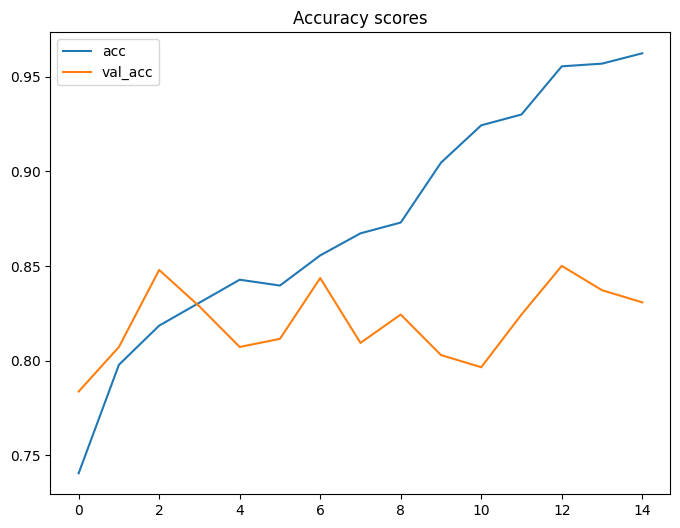

In [ ]:
#plot accuracy scores
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
model.load_weights("best_model_effnetB0.hdf5")
preds = model.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df['class_id']= pred
df.to_csv("final_submission115.csv", index=False)

37/37 [==============================] - 3s 35ms/step


EfficientNetB1 - Kept on Final Results


In [ ]:
#EfficienNetB1
base_model1 = tf.keras.applications.EfficientNetB1(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model1.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model1 = Model(inputs=base_model1.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model1.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

#model.summary()

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history = model1.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/50
132/132 [==============================] - 72s 441ms/step - loss: 2.0668 - acc: 0.7344 - val_loss: 1.7813 - val_acc: 0.7859 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 54s 407ms/step - loss: 1.5603 - acc: 0.8052 - val_loss: 1.4429 - val_acc: 0.7923 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 55s 413ms/step - loss: 1.1787 - acc: 0.8145 - val_loss: 1.0082 - val_acc: 0.8137 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 54s 411ms/step - loss: 0.8806 - acc: 0.8352 - val_loss: 0.8227 - val_acc: 0.8223 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 55s 412ms/step - loss: 0.6845 - acc: 0.8490 - val_loss: 0.7158 - val_acc: 0.8030 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 53s 402ms/step - loss: 0.5489 - acc: 0.8568 - val_loss: 0.7499 - val_acc: 0.7666 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 54s 409ms/step - loss: 0.4800 - acc: 0.8649 - val_loss: 0.

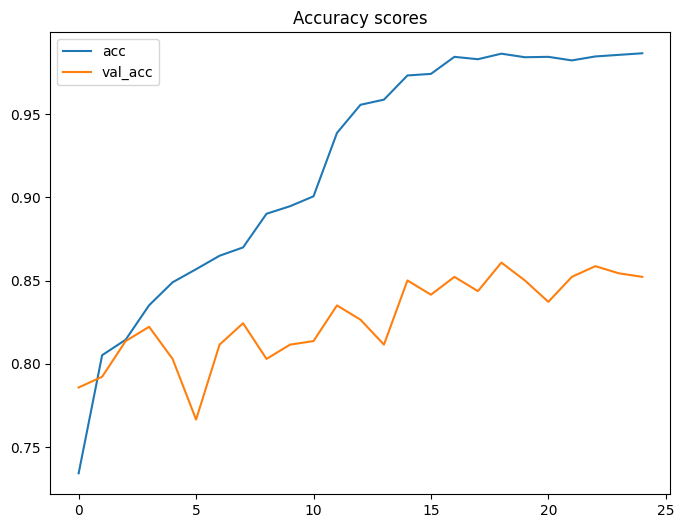

In [ ]:
#plot accuracy scores
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
model1.load_weights("best_model_effnetB1.hdf5")
preds = model1.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission52.csv", index=False)

37/37 [==============================] - 4s 43ms/step


EfficientNetB2 - Removed on final results


In [ ]:
#EfficientNetB2
base_model2 = tf.keras.applications.EfficientNetB2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-4, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-4, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model2 = Model(inputs=base_model2.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model2.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])


31790344/31790344 [==============================] - 0s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history2 = model2.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/30
132/132 [==============================] - 73s 445ms/step - loss: 4.5490 - acc: 0.7346 - val_loss: 3.8439 - val_acc: 0.7623 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - 54s 409ms/step - loss: 3.1308 - acc: 0.8083 - val_loss: 2.5692 - val_acc: 0.8116 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - 55s 413ms/step - loss: 1.9521 - acc: 0.8147 - val_loss: 1.5787 - val_acc: 0.7880 - lr: 0.0010
Epoch 4/30
132/132 [==============================] - 55s 412ms/step - loss: 1.2197 - acc: 0.8224 - val_loss: 0.9724 - val_acc: 0.8266 - lr: 0.0010
Epoch 5/30
132/132 [==============================] - 55s 413ms/step - loss: 0.8103 - acc: 0.8516 - val_loss: 0.7988 - val_acc: 0.8223 - lr: 0.0010
Epoch 6/30
132/132 [==============================] - 53s 399ms/step - loss: 0.6623 - acc: 0.8554 - val_loss: 0.8131 - val_acc: 0.7495 - lr: 0.0010
Epoch 7/30
132/132 [==============================] - 55s 413ms/step - loss: 0.5974 - acc: 0.8595 - val_loss: 0.

In [ ]:
model2.load_weights("best_model_effnetB2.hdf5")
preds = model2.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission53.csv", index=False)

37/37 [==============================] - 4s 46ms/step


EfficientNetB3 - All EfficientNetB3 are kept to the final results besides B3_2


In [ ]:
#EfficientNetB3
base_model3 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model3 = Model(inputs=base_model3.input, outputs=ouput1)
model3.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])



43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history3 = model3.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/50
132/132 [==============================] - 121s 461ms/step - loss: 1.6610 - acc: 0.7534 - val_loss: 1.2986 - val_acc: 0.8030 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 56s 420ms/step - loss: 0.8935 - acc: 0.8024 - val_loss: 0.7157 - val_acc: 0.7281 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 55s 417ms/step - loss: 0.5119 - acc: 0.8131 - val_loss: 0.4787 - val_acc: 0.7923 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 56s 420ms/step - loss: 0.3751 - acc: 0.8293 - val_loss: 0.3941 - val_acc: 0.7859 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 55s 417ms/step - loss: 0.3242 - acc: 0.8366 - val_loss: 0.3640 - val_acc: 0.8116 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 54s 409ms/step - loss: 0.2862 - acc: 0.8559 - val_loss: 0.4466 - val_acc: 0.7580 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - ETA: 0s - loss: 0.2898 - acc: 0.8521
Epoch 7: ReduceLROnP

In [ ]:
model3.load_weights("best_model_effnetB3.hdf5")
preds = model3.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission345.csv", index=False)

37/37 [==============================] - 5s 65ms/step


In [ ]:
#EfficientNetB3_1
base_model31 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model31.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model31 = Model(inputs=base_model31.input, outputs=ouput1)

model31.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history31 = model31.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/50
132/132 [==============================] - 114s 454ms/step - loss: 0.5577 - acc: 0.7477 - val_loss: 0.5082 - val_acc: 0.7944 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 55s 416ms/step - loss: 0.4432 - acc: 0.8043 - val_loss: 0.4523 - val_acc: 0.8009 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 54s 408ms/step - loss: 0.4014 - acc: 0.8238 - val_loss: 0.4738 - val_acc: 0.8158 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 56s 421ms/step - loss: 0.3615 - acc: 0.8421 - val_loss: 0.3739 - val_acc: 0.8244 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 53s 401ms/step - loss: 0.3316 - acc: 0.8585 - val_loss: 0.7586 - val_acc: 0.7002 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - ETA: 0s - loss: 0.3132 - acc: 0.8552
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 54s 404ms/step - loss: 0.3132 - acc: 0.8552 - val

In [ ]:
model31.load_weights("best_model_effnetB3_1.hdf5")
preds = model31.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df['class_id']= pred
df.to_csv("final_submission98.csv", index=False)

37/37 [==============================] - 5s 63ms/step


EfficientNet3_2 - Removed from the final resuts

In [ ]:
#EfficientNet3_2
base_model32 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model32.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-6, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model32 = Model(inputs=base_model32.input, outputs=ouput1)

model32.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history32 = model32.fit(train_gen, epochs=40, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/40
132/132 [==============================] - 114s 450ms/step - loss: 1.4532 - acc: 0.7455 - val_loss: 1.1085 - val_acc: 0.7495 - lr: 0.0010
Epoch 2/40
132/132 [==============================] - 56s 424ms/step - loss: 0.7985 - acc: 0.8083 - val_loss: 0.5796 - val_acc: 0.8094 - lr: 0.0010
Epoch 3/40
132/132 [==============================] - 56s 421ms/step - loss: 0.4795 - acc: 0.8212 - val_loss: 0.4127 - val_acc: 0.8201 - lr: 0.0010
Epoch 4/40
132/132 [==============================] - 56s 421ms/step - loss: 0.3532 - acc: 0.8283 - val_loss: 0.3392 - val_acc: 0.8223 - lr: 0.0010
Epoch 5/40
132/132 [==============================] - 54s 410ms/step - loss: 0.3021 - acc: 0.8357 - val_loss: 0.4443 - val_acc: 0.7109 - lr: 0.0010
Epoch 6/40
132/132 [==============================] - 56s 420ms/step - loss: 0.2820 - acc: 0.8335 - val_loss: 0.3248 - val_acc: 0.7987 - lr: 0.0010
Epoch 7/40
132/132 [==============================] - 55s 415ms/step - loss: 0.2529 - acc: 0.8552 - val_loss: 0

In [ ]:
model32.load_weights("best_model_effnetB3_2.hdf5")
preds = model32.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission649.csv", index=False)

37/37 [==============================] - 5s 63ms/step


EfficientNet3_3

In [ ]:
#EfficientNet3_3
base_model33 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model33.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model33 = Model(inputs=base_model33.input, outputs=ouput1)

model33.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history33 = model33.fit(train_gen, epochs=40, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/40
132/132 [==============================] - 113s 454ms/step - loss: 1.5542 - acc: 0.7422 - val_loss: 1.2694 - val_acc: 0.7281 - lr: 0.0010
Epoch 2/40
132/132 [==============================] - 55s 418ms/step - loss: 0.9288 - acc: 0.7967 - val_loss: 0.7594 - val_acc: 0.7516 - lr: 0.0010
Epoch 3/40
132/132 [==============================] - 55s 418ms/step - loss: 0.5802 - acc: 0.8126 - val_loss: 0.4781 - val_acc: 0.8180 - lr: 0.0010
Epoch 4/40
132/132 [==============================] - 55s 418ms/step - loss: 0.4281 - acc: 0.8262 - val_loss: 0.3950 - val_acc: 0.8051 - lr: 0.0010
Epoch 5/40
132/132 [==============================] - 53s 402ms/step - loss: 0.3649 - acc: 0.8316 - val_loss: 0.3997 - val_acc: 0.8137 - lr: 0.0010
Epoch 6/40
132/132 [==============================] - 56s 420ms/step - loss: 0.3257 - acc: 0.8492 - val_loss: 0.3661 - val_acc: 0.8223 - lr: 0.0010
Epoch 7/40
132/132 [==============================] - 54s 404ms/step - loss: 0.3034 - acc: 0.8571 - val_loss: 0

In [ ]:
model33.load_weights("best_model_effnetB3_3.hdf5")
preds = model33.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission657.csv", index=False)

37/37 [==============================] - 5s 64ms/step


EfficientNet3_4

In [ ]:
#EfficientNet3_4
base_model34 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model34.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model34 = Model(inputs=base_model34.input, outputs=ouput1)

model34.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_4.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history34 = model34.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])

Epoch 1/50
132/132 [==============================] - 114s 454ms/step - loss: 1.0874 - acc: 0.7491 - val_loss: 0.8393 - val_acc: 0.8009 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 55s 415ms/step - loss: 0.6760 - acc: 0.8045 - val_loss: 0.5412 - val_acc: 0.8180 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 54s 406ms/step - loss: 0.4662 - acc: 0.8181 - val_loss: 0.5750 - val_acc: 0.6488 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 56s 419ms/step - loss: 0.3557 - acc: 0.8304 - val_loss: 0.3771 - val_acc: 0.7987 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 55s 416ms/step - loss: 0.3221 - acc: 0.8402 - val_loss: 0.3546 - val_acc: 0.8158 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 55s 418ms/step - loss: 0.2766 - acc: 0.8495 - val_loss: 0.3306 - val_acc: 0.8223 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 53s 402ms/step - loss: 0.2454 - acc: 0.8640 - val_loss: 0

In [ ]:
model34.load_weights("best_model_effnetB3_4.hdf5")
preds = model34.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission658.csv", index=False)

37/37 [==============================] - 5s 63ms/step


EfficientNet3_5

In [ ]:
#EfficientNet3_5
base_model35 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model35.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'sigmoid')(x)

model35 = Model(inputs=base_model35.input, outputs=ouput1)

model35.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_5.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)


history35 = model35.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/20
132/132 [==============================] - 113s 456ms/step - loss: 1.7420 - acc: 0.7429 - val_loss: 1.4292 - val_acc: 0.7859 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 55s 418ms/step - loss: 1.0372 - acc: 0.8029 - val_loss: 0.7788 - val_acc: 0.8116 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 55s 418ms/step - loss: 0.6666 - acc: 0.8024 - val_loss: 0.5281 - val_acc: 0.7859 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 56s 424ms/step - loss: 0.4597 - acc: 0.8243 - val_loss: 0.4275 - val_acc: 0.8137 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 55s 417ms/step - loss: 0.3823 - acc: 0.8254 - val_loss: 0.4251 - val_acc: 0.8137 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 54s 403ms/step - loss: 0.3416 - acc: 0.8378 - val_loss: 0.4801 - val_acc: 0.7859 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - ETA: 0s - loss: 0.3120 - acc: 0.8618
Epoch 7: ReduceLROnP

In [ ]:
model35.load_weights("best_model_effnetB3_5.hdf5")
preds = model35.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission659.csv", index=False)

37/37 [==============================] - 6s 64ms/step


EfficientNet3_6

In [ ]:
#EfficientNet3_6
base_model36 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model36.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model36 = Model(inputs=base_model36.input, outputs=ouput1)

model36.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_6.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history36 = model36.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/50
132/132 [==============================] - 113s 453ms/step - loss: 1.6223 - acc: 0.7515 - val_loss: 1.2469 - val_acc: 0.7152 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 55s 415ms/step - loss: 0.8234 - acc: 0.8017 - val_loss: 0.6849 - val_acc: 0.7623 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 55s 415ms/step - loss: 0.4602 - acc: 0.8164 - val_loss: 0.4188 - val_acc: 0.7987 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 56s 420ms/step - loss: 0.3539 - acc: 0.8207 - val_loss: 0.3409 - val_acc: 0.8180 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 54s 404ms/step - loss: 0.2956 - acc: 0.8445 - val_loss: 0.3501 - val_acc: 0.8244 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - ETA: 0s - loss: 0.2840 - acc: 0.8521
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 53s 403ms/step - loss: 0.2840 - acc: 0.8521 - val

In [ ]:
model36.load_weights("best_model_effnetB3_6.hdf5")
preds = model36.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission682.csv", index=False)


37/37 [==============================] - 5s 64ms/step


EfficientNet3_7

In [ ]:
#EfficientNet3_7
base_model37 = tf.keras.applications.EfficientNetB3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model37.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model37 = Model(inputs=base_model37.input, outputs=ouput1)

model37.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetB3_7.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history37 = model37.fit(train_gen, epochs=70, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/70
132/132 [==============================] - 113s 452ms/step - loss: 1.0974 - acc: 0.7584 - val_loss: 0.9110 - val_acc: 0.7859 - lr: 0.0010
Epoch 2/70
132/132 [==============================] - 56s 419ms/step - loss: 0.7061 - acc: 0.8043 - val_loss: 0.5892 - val_acc: 0.7859 - lr: 0.0010
Epoch 3/70
132/132 [==============================] - 55s 413ms/step - loss: 0.4917 - acc: 0.8178 - val_loss: 0.4369 - val_acc: 0.8116 - lr: 0.0010
Epoch 4/70
132/132 [==============================] - 55s 416ms/step - loss: 0.3703 - acc: 0.8297 - val_loss: 0.3886 - val_acc: 0.8030 - lr: 0.0010
Epoch 5/70
132/132 [==============================] - 56s 420ms/step - loss: 0.3167 - acc: 0.8409 - val_loss: 0.3223 - val_acc: 0.8223 - lr: 0.0010
Epoch 6/70
132/132 [==============================] - 54s 403ms/step - loss: 0.2918 - acc: 0.8499 - val_loss: 0.3243 - val_acc: 0.8051 - lr: 0.0010
Epoch 7/70
132/132 [==============================] - ETA: 0s - loss: 0.2570 - acc: 0.8621
Epoch 7: ReduceLROnP

In [ ]:
model37.load_weights("best_model_effnetB3_7.hdf5")
preds = model37.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission8924.csv", index=False)

37/37 [==============================] - 5s 63ms/step


EfficientNetV2B0 - Kept for final results


In [ ]:
#EfficientNetV2B0
base_model4 = tf.keras.applications.EfficientNetV2B0(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model4.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model4 = Model(inputs=base_model4.input, outputs=ouput1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model4.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetV2B0.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history4 = model4.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/25
132/132 [==============================] - 71s 434ms/step - loss: 2.0740 - acc: 0.7422 - val_loss: 1.7447 - val_acc: 0.8116 - lr: 0.0010
Epoch 2/25
132/132 [==============================] - 54s 408ms/step - loss: 1.5710 - acc: 0.7931 - val_loss: 1.3477 - val_acc: 0.8030 - lr: 0.0010
Epoch 3/25
132/132 [==============================] - 54s 408ms/step - loss: 1.2328 - acc: 0.8067 - val_loss: 1.0427 - val_acc: 0.8180 - lr: 0.0010
Epoch 4/25
132/132 [==============================] - 54s 406ms/step - loss: 0.9583 - acc: 0.8202 - val_loss: 0.8718 - val_acc: 0.8030 - lr: 0.0010
Epoch 5/25
132/132 [==============================] - 54s 410ms/step - loss: 0.7340 - acc: 0.8340 - val_loss: 0.6841 - val_acc: 0.8394 - lr: 0.0010
Epoch 6/25
132/132 [==============================] - 54s 409ms/step - loss: 0.6137 - acc: 0.8390 - val_loss: 0.6093 - val_acc: 0.8244 - lr: 0.0010
Epoch 7/25
132/132 [==============================] - 54s 407ms/step - loss: 0.5300 - acc: 0.8445 - val_loss: 0.

In [ ]:
model4.load_weights("best_model_effnetV2B0.hdf5")
preds = model4.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission2356.csv", index=False)

37/37 [==============================] - 3s 29ms/step


EfficientNetV2B1 - Kept for final results

In [ ]:
#EfficientNetV2B1
base_model5 = tf.keras.applications.EfficientNetV2B1(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model5.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model5 = Model(inputs=base_model5.input, outputs=ouput1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model5.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])


28456008/28456008 [==============================] - 0s 0us/step


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetV2B1.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history5 = model5.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/25
132/132 [==============================] - 71s 434ms/step - loss: 2.1370 - acc: 0.7284 - val_loss: 1.9618 - val_acc: 0.7987 - lr: 0.0010
Epoch 2/25
132/132 [==============================] - 54s 410ms/step - loss: 1.6887 - acc: 0.7786 - val_loss: 1.4708 - val_acc: 0.7987 - lr: 0.0010
Epoch 3/25
132/132 [==============================] - 55s 415ms/step - loss: 1.3062 - acc: 0.8081 - val_loss: 1.1332 - val_acc: 0.8308 - lr: 0.0010
Epoch 4/25
132/132 [==============================] - 54s 412ms/step - loss: 1.0227 - acc: 0.8178 - val_loss: 0.8897 - val_acc: 0.8158 - lr: 0.0010
Epoch 5/25
132/132 [==============================] - 54s 411ms/step - loss: 0.8002 - acc: 0.8407 - val_loss: 0.7365 - val_acc: 0.8437 - lr: 0.0010
Epoch 6/25
132/132 [==============================] - 55s 415ms/step - loss: 0.6933 - acc: 0.8357 - val_loss: 0.6781 - val_acc: 0.8158 - lr: 0.0010
Epoch 7/25
132/132 [==============================] - 52s 395ms/step - loss: 0.6301 - acc: 0.8307 - val_loss: 0.

In [ ]:
model5.load_weights("best_model_effnetV2B1.hdf5")
preds = model5.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission412.csv", index=False)

37/37 [==============================] - 3s 25ms/step


EfficientNetV2B2 - Removed from final results


In [ ]:
#EfficientNetV2B2
base_model6 = tf.keras.applications.EfficientNetV2B2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model6.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model6 = Model(inputs=base_model6.input, outputs=ouput1)

model6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['acc'])

35839040/35839040 [==============================] - 0s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetV2B2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history6 = model6.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/20
132/132 [==============================] - 110s 442ms/step - loss: 2.1328 - acc: 0.7396 - val_loss: 1.8519 - val_acc: 0.7794 - lr: 0.0010
Epoch 2/20
132/132 [==============================] - 54s 411ms/step - loss: 1.6672 - acc: 0.7869 - val_loss: 1.3848 - val_acc: 0.8308 - lr: 0.0010
Epoch 3/20
132/132 [==============================] - 55s 413ms/step - loss: 1.2652 - acc: 0.8100 - val_loss: 1.1094 - val_acc: 0.8094 - lr: 0.0010
Epoch 4/20
132/132 [==============================] - 55s 417ms/step - loss: 1.0148 - acc: 0.8181 - val_loss: 0.9449 - val_acc: 0.7923 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - 55s 412ms/step - loss: 0.7977 - acc: 0.8209 - val_loss: 0.7286 - val_acc: 0.8073 - lr: 0.0010
Epoch 6/20
132/132 [==============================] - 55s 415ms/step - loss: 0.7977 - acc: 0.7834 - val_loss: 0.6598 - val_acc: 0.8244 - lr: 0.0010
Epoch 7/20
132/132 [==============================] - 55s 415ms/step - loss: 0.6583 - acc: 0.8067 - val_loss: 0

In [ ]:

model6.load_weights("best_model_effnetV2B2.hdf5")
preds = model6.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission9876.csv", index=False)

37/37 [==============================] - 3s 27ms/step


EfficientNetV2B3 - Kept for final results

In [ ]:
#EfficientNetV2B3
base_model7 = tf.keras.applications.EfficientNetV2B3(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model7.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model7 = Model(inputs=base_model7.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model7.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

52606240/52606240 [==============================] - 0s 0us/step


In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_effnetV2B3.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)
history7 = model7.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/30
132/132 [==============================] - 79s 457ms/step - loss: 2.2158 - acc: 0.7153 - val_loss: 2.1838 - val_acc: 0.7645 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - 55s 417ms/step - loss: 1.7704 - acc: 0.7620 - val_loss: 1.5101 - val_acc: 0.7859 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - 55s 415ms/step - loss: 1.3856 - acc: 0.7919 - val_loss: 1.1772 - val_acc: 0.7944 - lr: 0.0010
Epoch 4/30
132/132 [==============================] - 55s 417ms/step - loss: 1.0872 - acc: 0.8083 - val_loss: 0.9348 - val_acc: 0.8094 - lr: 0.0010
Epoch 5/30
132/132 [==============================] - 55s 415ms/step - loss: 0.8850 - acc: 0.8090 - val_loss: 0.7831 - val_acc: 0.8073 - lr: 0.0010
Epoch 6/30
132/132 [==============================] - 55s 418ms/step - loss: 0.7368 - acc: 0.8078 - val_loss: 0.6423 - val_acc: 0.8394 - lr: 0.0010
Epoch 7/30
132/132 [==============================] - 55s 418ms/step - loss: 0.6725 - acc: 0.8090 - val_loss: 0.

In [ ]:
model7.load_weights("best_model_effnetV2B3.hdf5")
preds = model7.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission4244.csv", index=False)

37/37 [==============================] - 4s 41ms/step


In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)


datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=40, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=40, subset= "validation")

EfficientNetV2M - Kept on final results


In [ ]:
#EfficientNetV2M
base_model14 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model14.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(224, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
x = Dense(224, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.2)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model14 = Model(inputs=base_model14.input, outputs=ouput1)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model14.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

214201816/214201816 [==============================] - 1s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

history = model14.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])


Epoch 1/50
106/106 [==============================] - 122s 828ms/step - loss: 1.3397 - acc: 0.7222 - val_loss: 1.1366 - val_acc: 0.7794 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - 68s 639ms/step - loss: 1.0582 - acc: 0.7862 - val_loss: 1.0138 - val_acc: 0.7623 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - ETA: 0s - loss: 0.8630 - acc: 0.8121
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
106/106 [==============================] - 68s 637ms/step - loss: 0.8630 - acc: 0.8121 - val_loss: 1.3731 - val_acc: 0.7516 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 73s 683ms/step - loss: 0.7183 - acc: 0.8468 - val_loss: 0.7146 - val_acc: 0.8201 - lr: 3.0000e-04
Epoch 5/50
106/106 [==============================] - 68s 638ms/step - loss: 0.6354 - acc: 0.8604 - val_loss: 0.6768 - val_acc: 0.8201 - lr: 3.0000e-04
Epoch 6/50
106/106 [==============================] - 72s 678ms/step - loss: 0.5735 - acc: 0.87

In [ ]:
model14.load_weights("best_model_EfficientNetV2M.hdf5")
preds14 = model14.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds14)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_50epochs_40.csv", index=False)

37/37 [==============================] - 9s 109ms/step


In [ ]:

datagen = ImageDataGenerator(
        rotation_range = 2,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range=[0.6,1.4],
        fill_mode= "nearest",validation_split=0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=45, subset="training")
valid_gen = datagen.flow(X_train, y_train, batch_size=45, subset= "validation")

EfficientNetV2M_2 - Kept for final results

In [ ]:
#EfficientNetV2M_2
base_model16 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model16 = Model(inputs=base_model16.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model16.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_2.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

history = model16.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])


Epoch 1/10
94/94 [==============================] - 127s 994ms/step - loss: 2.1653 - acc: 0.7268 - val_loss: 2.6003 - val_acc: 0.7409 - lr: 0.0010
Epoch 2/10
94/94 [==============================] - 74s 784ms/step - loss: 1.7798 - acc: 0.7800 - val_loss: 1.5610 - val_acc: 0.8158 - lr: 0.0010
Epoch 3/10
94/94 [==============================] - 70s 739ms/step - loss: 1.4803 - acc: 0.8076 - val_loss: 1.3378 - val_acc: 0.8094 - lr: 0.0010
Epoch 4/10
94/94 [==============================] - ETA: 0s - loss: 1.2212 - acc: 0.8062
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
94/94 [==============================] - 70s 738ms/step - loss: 1.2212 - acc: 0.8062 - val_loss: 1.1431 - val_acc: 0.7923 - lr: 0.0010
Epoch 5/10
94/94 [==============================] - 74s 786ms/step - loss: 0.9986 - acc: 0.8438 - val_loss: 1.0149 - val_acc: 0.8308 - lr: 3.0000e-04
Epoch 6/10
94/94 [==============================] - 70s 741ms/step - loss: 0.9103 - acc: 0.8630 - val_loss: 0.9

In [ ]:
model16.load_weights('best_model_EfficientNetV2M_2.hdf5')
preds = model16.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_vol2.csv", index=False)

37/37 [==============================] - 8s 92ms/step


EfficientNetV2M_3 - Kept for final results

In [ ]:
#EfficientNetV2M_3
base_model20 = tf.keras.applications.EfficientNetV2M(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model20.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model20 = Model(inputs=base_model20.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model20.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])



In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
chkpt = ModelCheckpoint(filepath='best_model_EfficientNetV2M_3.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=True)

history = model20.fit(train_gen, epochs=40, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt])


Epoch 1/40
94/94 [==============================] - 134s 1s/step - loss: 2.1522 - acc: 0.7206 - val_loss: 1.8154 - val_acc: 0.7923 - lr: 0.0010
Epoch 2/40
94/94 [==============================] - 70s 741ms/step - loss: 1.6792 - acc: 0.8002 - val_loss: 1.5611 - val_acc: 0.7880 - lr: 0.0010
Epoch 3/40
94/94 [==============================] - 75s 793ms/step - loss: 1.3822 - acc: 0.8090 - val_loss: 1.2771 - val_acc: 0.8073 - lr: 0.0010
Epoch 4/40
94/94 [==============================] - 74s 783ms/step - loss: 1.1348 - acc: 0.8088 - val_loss: 1.0346 - val_acc: 0.8094 - lr: 0.0010
Epoch 5/40
94/94 [==============================] - 74s 787ms/step - loss: 0.9115 - acc: 0.8340 - val_loss: 0.8249 - val_acc: 0.8330 - lr: 0.0010
Epoch 6/40
94/94 [==============================] - 70s 740ms/step - loss: 0.7598 - acc: 0.8376 - val_loss: 0.7176 - val_acc: 0.8330 - lr: 0.0010
Epoch 7/40
94/94 [==============================] - ETA: 0s - loss: 0.6480 - acc: 0.8511
Epoch 7: ReduceLROnPlateau reducing l

In [ ]:
model20.load_weights('best_model_EfficientNetV2M_3.hdf5')
preds = model20.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission_EfficientNetV2M_vol3.csv", index=False)

37/37 [==============================] - 8s 92ms/step


MOBILENET - Kept for final results

In [ ]:
#MobileNet
base_model8 = tf.keras.applications.MobileNet(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model8.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-3))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model8 = Model(inputs=base_model8.input, outputs=ouput1)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 * 0.1)
model8.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
model8.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                           

In [ ]:
#checkpoints

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_Mobnet.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history8 = model8.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/30
94/94 [==============================] - 61s 587ms/step - loss: 2.0380 - acc: 0.7446 - val_loss: 2.2276 - val_acc: 0.7323 - lr: 0.0010
Epoch 2/30
94/94 [==============================] - 53s 564ms/step - loss: 1.6355 - acc: 0.8052 - val_loss: 1.7453 - val_acc: 0.7987 - lr: 0.0010
Epoch 3/30
94/94 [==============================] - 53s 564ms/step - loss: 1.3399 - acc: 0.8238 - val_loss: 1.3112 - val_acc: 0.7880 - lr: 0.0010
Epoch 4/30
94/94 [==============================] - 53s 568ms/step - loss: 1.0882 - acc: 0.8340 - val_loss: 1.1660 - val_acc: 0.7302 - lr: 0.0010
Epoch 5/30
94/94 [==============================] - 53s 562ms/step - loss: 0.8727 - acc: 0.8447 - val_loss: 0.8331 - val_acc: 0.8308 - lr: 0.0010
Epoch 6/30
94/94 [==============================] - 53s 566ms/step - loss: 0.7059 - acc: 0.8559 - val_loss: 0.7298 - val_acc: 0.8351 - lr: 0.0010
Epoch 7/30
94/94 [==============================] - 52s 558ms/step - loss: 0.6013 - acc: 0.8540 - val_loss: 0.9246 - val_acc

In [ ]:
model8.load_weights("best_model_Mobnet.hdf5")
preds = model8.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission46.csv", index=False)


37/37 [==============================] - 1s 18ms/step


MobileNetV2 - Removed from final results




In [ ]:
#MobileNetV2
base_model9 = tf.keras.applications.MobileNetV2(include_top=False,
                                     weights='imagenet',
                                     input_shape=(224, 224, 3))
x = base_model9.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-2))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation=None, kernel_regularizer = L1L2(l1=1e-5, l2=1e-2))(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.3)(x)
ouput1 = Dense(3, activation= 'softmax')(x)

model9 = Model(inputs=base_model9.input, outputs=ouput1)

model9.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['acc'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#checkpoints
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00000001)
chkpt = ModelCheckpoint(filepath='best_model_MobnetV2.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_loss', restore_best_weights=True)

history9 = model9.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[learning_rate_reduction, chkpt, early_stopping])


Epoch 1/20
94/94 [==============================] - 82s 585ms/step - loss: 8.0417 - acc: 0.7365 - val_loss: 4.1348 - val_acc: 0.5782 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 53s 563ms/step - loss: 1.9582 - acc: 0.7876 - val_loss: 1.4256 - val_acc: 0.6360 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 53s 568ms/step - loss: 0.7926 - acc: 0.7986 - val_loss: 1.0607 - val_acc: 0.7452 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 54s 572ms/step - loss: 0.5602 - acc: 0.8235 - val_loss: 0.6150 - val_acc: 0.7837 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 52s 556ms/step - loss: 0.5145 - acc: 0.8316 - val_loss: 0.6886 - val_acc: 0.7923 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - ETA: 0s - loss: 0.4963 - acc: 0.8354
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
94/94 [==============================] - 52s 556ms/step - loss: 0.4963 - acc: 0.8354 - val_loss: 1.3371 -

In [ ]:

model9.load_weights("best_model_MobnetV2.hdf5")
preds = model9.predict(X_test)
labelled_preds = one_hot_encoder.inverse_transform(preds)
pred = pd.DataFrame(labelled_preds, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submission235543.csv", index=False)

37/37 [==============================] - 2s 21ms/step


Soft Voting


Get the final prediction while we keep only the 15 predictions

In [ ]:
model1.load_weights("best_model_effnetB1.hdf5")
preds1 = model1.predict(X_test)

model3.load_weights("best_model_effnetB3.hdf5")
preds3 = model3.predict(X_test)

model31.load_weights("best_model_effnetB3_1.hdf5")
preds31 = model31.predict(X_test)

model33.load_weights("best_model_effnetB3_3.hdf5")
preds33 = model33.predict(X_test)

model34.load_weights("best_model_effnetB3_4.hdf5")
preds34 = model34.predict(X_test)

model35.load_weights("best_model_effnetB3_5.hdf5")
preds35 = model35.predict(X_test)

model36.load_weights("best_model_effnetB3_6.hdf5")
preds37 = model36.predict(X_test)

model37.load_weights("best_model_effnetB3_7.hdf5")
preds38 = model37.predict(X_test)

model4.load_weights("best_model_effnetV2B0.hdf5")
preds4 = model4.predict(X_test)

model5.load_weights("best_model_effnetV2B1.hdf5")
preds5 = model5.predict(X_test)

model7.load_weights("best_model_effnetV2B3.hdf5")
preds7 = model7.predict(X_test)

model14.load_weights('best_model_EfficientNetV2M.hdf5')
preds14 = model14.predict(X_test)

model16.load_weights('best_model_EfficientNetV2M_2.hdf5')
preds16 = model16.predict(X_test)

model20.load_weights('best_model_EfficientNetV2M_3.hdf5')
preds20 = model20.predict(X_test)

model8.load_weights("best_model_Mobnet.hdf5")
preds8 = model8.predict(X_test)

37/37 [==============================] - 1s 18ms/step


In [ ]:
a = np.mean( np.array([preds1, preds3, preds31, preds33, preds34, preds35, preds37, preds38, preds4, preds5, preds7, preds8, preds14, preds16, preds20]), axis=0 )
final_labels = one_hot_encoder.inverse_transform(a)
final_labels


array([[1],
       [2],
       [0],
       ...,
       [0],
       [2],
       [1]])

Final Results

In [ ]:

pred = pd.DataFrame(final_labels, columns =["class_id"])
df = pd.read_csv('submission3.csv')
df ['class_id']= pred
df.to_csv("final_submissionn.csv", index=False)